In [1]:
import sys,os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.fft

In [33]:
import datetime

In [3]:
dirP_str = os.path.join(os.environ['HOME'], 'Python/Python-Optics/Libraries')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
import FourierOpticsLib as FO

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [5]:
def torch_propagate(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_dist:float,lam:float):
    """
    Propagates an electric field a distance z_dist
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (2D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (2D, setup to broadcast)
    
    z_dist: float
    - distance to propagate the wave Ein
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
    Etfft *= torch.exp(1j*2*np.pi*z_dist/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Etfft)
    
    return Eout
    
def torch_propagate_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
    Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

In [6]:
dtype = torch.complex64  # fft required data type

## Build Hologram using Standard Fourier Optics Library

In [7]:
lam = 355e-9  # wavelength
z_det = 5e-2  # detector z position

# define a square simulation grid
x_max = 0.5e-3  # max grid dimension
dx = 1e-6  # grid spacing

Nparticles = 4

# create the full coordinate grid
grid0 = FO.Coordinate_Grid((x_max,dx))

In [8]:
particle_lst = []

for _ in range(Nparticles):
    # add a particle
    particle_lst.append({
        'x':(np.random.rand()-0.5)*0.5e-3,
        'y':(np.random.rand()-0.5)*0.5e-3,
        'z':np.random.rand()*z_det, # x,y,z position
        'diameter':np.random.rand()*100e-6
                    })

In [9]:
z_lst = [p['z'] for p in particle_lst]
z_sort_idx = np.argsort(z_lst)

In [10]:
p_obj_lst = []

for idx in z_sort_idx:
    p_obj_lst.append(FO.Stop(particle_lst[idx]['diameter'],
                             particle_lst[idx]['z'],
                             grid0,
                             offset=[particle_lst[idx]['x'],particle_lst[idx]['y']],
                             invert=True))

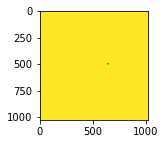

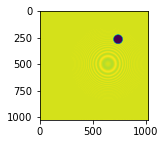

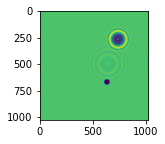

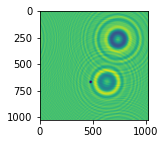

In [11]:
E1 = FO.Efield(lam,grid0)
for p in p_obj_lst:
    p.propagate(E1)
    plt.figure(figsize=(2,2))
    plt.imshow(np.abs(E1.field)**2)
E1.propagate_to(z_det)

In [12]:
Iholo = np.abs(E1.field)**2

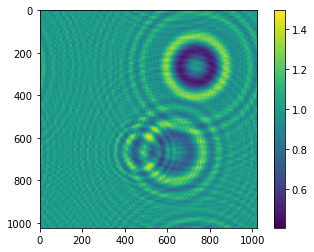

In [13]:
plt.figure()
plt.imshow(Iholo)
plt.colorbar()

## Reconstruct the Hologram

In [34]:
fx = torch.fft.fftfreq(Iholo.shape[1],grid0.dx,device=device)[None,None,:]
fy = torch.fft.fftfreq(Iholo.shape[0],grid0.dy,device=device)[None,:,None]
z_rec = torch.tensor(np.linspace(0,z_det,500),device=device)[:,None,None]
E_input = torch.tensor(Iholo,device=device,dtype=dtype)[None,:,:]

In [35]:
start_time = datetime.datetime.now()
Eres = torch_holo_set(E_input,fx,fy,z_rec,lam)
end_time = datetime.datetime.now()

In [40]:
exec_time = end_time-start_time
print(f'executed {z_rec.detach().cpu().numpy().size} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/z_rec.detach().cpu().numpy().size} seconds per plane')

executed 500 planes in 0.374587 seconds
 for 0.000749174 seconds per plane


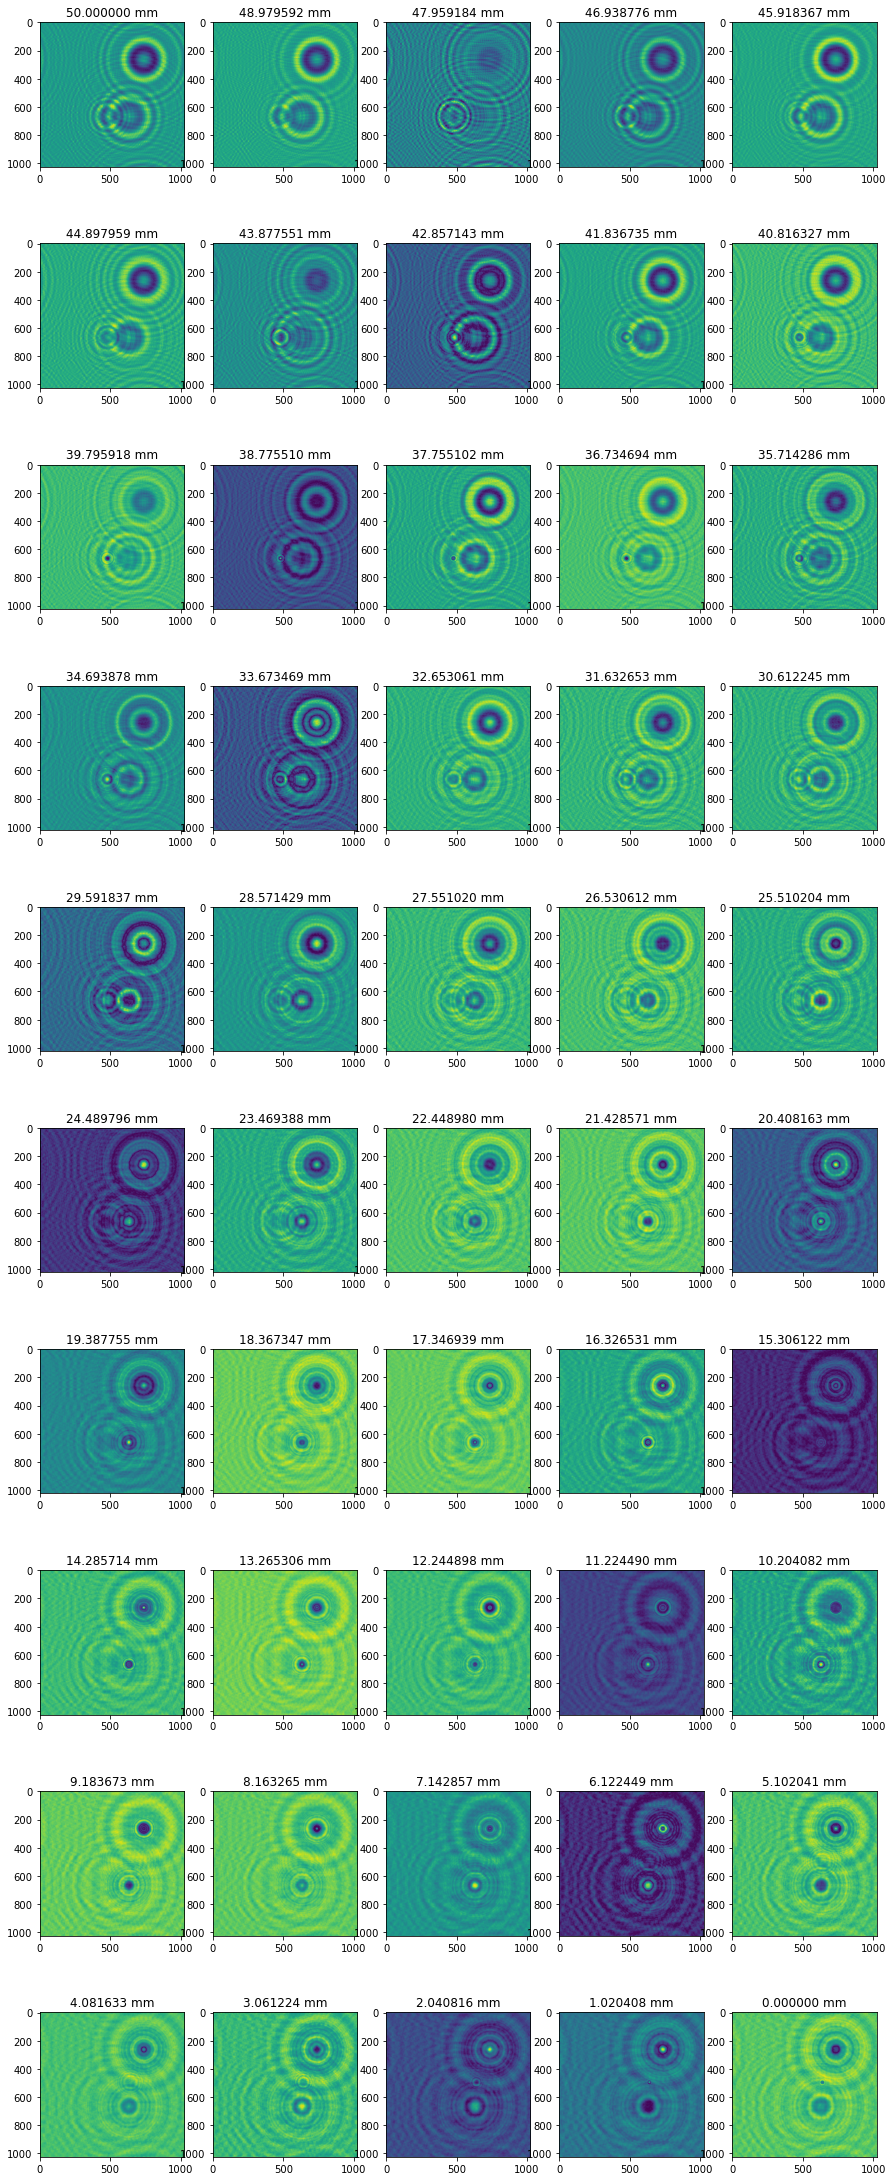

In [32]:
fig_cols = 5
fig_rows = np.int(np.ceil(z_rec.detach().cpu().numpy().size/fig_cols))

Eplt = np.abs(Eres.detach().cpu().numpy())

fig,ax_lst = plt.subplots(fig_rows,fig_cols,figsize=(15,4*fig_rows))
ax_lst = ax_lst.ravel()
for idx,z in enumerate(z_rec.detach().cpu().numpy()):
    ax = ax_lst[idx]
    ax.imshow(Eplt[idx,:,:])
    ax.set_title("%f mm"%((z_det-z)*1e3))

In [19]:
(fx*fy).shape

torch.Size([1024, 1024, 1])

In [16]:
torch.__version__

'1.3.1'

In [17]:
torch

<module 'torch' from '/glade/u/home/mhayman/miniconda3/envs/ml-torch/lib/python3.7/site-packages/torch/__init__.py'>